<a href="https://colab.research.google.com/github/oolonglilfox/CSC2516Project/blob/main/csc413_group200_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In [2]:
!pip install kornia cleverhans

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.1/628.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 3.4 MB/s eta 0:00:00


In [3]:
# Libraries
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
import torch.utils.data.dataloader as Data
import torch.nn as nn
from torch.nn import DataParallel
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, datasets
from torchvision.datasets import MNIST, CIFAR10
from torchvision.transforms import InterpolationMode
import numpy as np
import csv
import os
import io
import kornia
import time
from tqdm import tqdm
from PIL import Image
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.carlini_wagner_l2 import carlini_wagner_l2
import warnings

warnings.filterwarnings("ignore")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Model Building


In [5]:
class BasicBlock(nn.Module):
   # define basic building block of a ResNet - a two-layer convolutiona neural network with a residual connection
    expansion = 1 # class-level variable

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        # define the 2 convolutional layers with batch normalization
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        # define shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Bottleneck(nn.Module):
    # building block needed in the ResNet architecture
    expansion = 4 # adjust number of output channels in residual branch of the block
    
    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class denoising_block(nn.Module):
    def __init__(self, in_planes, ksize, filter_type):
        super(denoising_block, self).__init__()
        self.in_planes = in_planes
        self.ksize = ksize
        self.filter_type = filter_type
        self.conv = nn.Conv2d(in_channels=in_planes, out_channels=in_planes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        if self.filter_type == 'Median_Filter':
            x_denoised = kornia.filters.median_blur(x, (self.ksize, self.ksize))
        elif self.filter_type == 'Mean_Filter':
            x_denoised = kornia.filters.box_blur(x, (self.ksize, self.ksize))
        elif self.filter_type == 'Gaussian_Filter':
            x_denoised = kornia.filters.gaussian_blur2d(x, (self.ksize, self.ksize), (0.3 * ((x.shape[3] - 1) * 0.5 - 1) + 0.8, 0.3 * ((x.shape[2] - 1) * 0.5 - 1) + 0.8))
        new_x = x + self.conv(x_denoised)
        return new_x

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, whether_denoising=False, filter_type="Mean_Filter", ksize=3):
        super(ResNet, self).__init__()
        if whether_denoising:
            self.denoising_block1 = denoising_block(in_planes=64, ksize=ksize, filter_type=filter_type)
            self.denoising_block2 = denoising_block(in_planes=64, ksize=ksize, filter_type=filter_type)
        self.whether_denoising = whether_denoising
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        if self.whether_denoising:
            out = self.denoising_block1(out)
        out = self.layer1(out)
        if self.whether_denoising:
            out = self.denoising_block2(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [6]:
def ResNet18(whether_denoising=False, filter_type="Mean_Filter", ksize=3):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10, whether_denoising=whether_denoising, filter_type=filter_type, ksize=ksize)

def ResNet34(whether_denoising=False, filter_type="Mean_Filter", ksize=3):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=10, whether_denoising=whether_denoising, filter_type=filter_type, ksize=ksize)

def ResNet50(whether_denoising=False, filter_type="Mean_Filter", ksize=3):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=10, whether_denoising=whether_denoising, filter_type=filter_type, ksize=ksize)

def ResNet101(whether_denoising=False, filter_type="Mean_Filter", ksize=3):
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes=10, whether_denoising=whether_denoising, filter_type=filter_type, ksize=ksize)

def ResNet152(whether_denoising=False, filter_type="Mean_Filter", ksize=3):
    return ResNet(Bottleneck, [3, 8, 36, 3], num_classes=10, whether_denoising=whether_denoising, filter_type=filter_type, ksize=ksize)

def test():
    from torch.autograd import Variable
    net = ResNet18(whether_denoising=True, filter_type="Median_Filter", ksize=3)
    x = Variable(torch.randn(1, 3, 32, 32), requires_grad=True)
    y = net(x)
    print(y)

def denoising_block_test(filter_type):
    from torch.autograd import Variable
    denoising_block1 = denoising_block(in_planes=32, ksize=3, filter_type=filter_type)
    x = Variable(torch.ones(2, 64, 32, 32), requires_grad=True)
    y = denoising_block1(x)
    print(y)
    y.backward(x)
    print(x.grad)

# Data transformation
Countering Adversarial Images Using Input Transformations

In [7]:
import math

def denoise_tv_bregman(image, weight, max_iter=100, eps=1e-3):
  if image.is_cuda:
    image = image.cpu()
  image = atleast_3d(image)

  img_shape = list(image.shape)
  rows = img_shape[0]
  rows2 = rows + 2
  cols = img_shape[1]
  cols2 = cols + 2
  dims = img_shape[2]
  total = rows * cols * dims
  shape_extend = (rows2, cols2, dims)
  # out is firstly created as zeros-like tensor with size as shape_extend
  out = torch.zeros(shape_extend, dtype=torch.float)

  dx = out.clone().detach()
  dy = out.clone().detach()
  bx = out.clone().detach()
  by = out.clone().detach()

  lam = 2 * weight
  rmse = float("inf")
  norm = (weight + 4 * lam)

  out_rows, out_cols = out.shape[:2]
  out[1:out_rows-1, 1:out_cols-1] = image

  out = fill_extend(image, out)

  i = 0
  regularization = torch.mul(image, weight)
  # iterative optimization method
  # split-Bregman iteration
  while i < max_iter and rmse > eps:
    uprev = out[1:-1, 1:-1, :]

    ux = out[1:-1, 2:, :] - uprev
    uy = out[2:, 1:-1, :] - uprev

    unew = torch.div(
        (torch.mul((out[2:, 1:-1, :]
                + out[0:-2, 1:-1, :]
                + out[1:-1, 2:, :]
                + out[1:-1, 0:-2, :]

                + dx[1:-1, 0:-2, :]
                - dx[1:-1, 1:-1, :]
                + dy[0:-2, 1:-1, :]
                - dy[1:-1, 1:-1, :]

                - bx[1:-1, 0:-2, :]
                + bx[1:-1, 1:-1, :]
                - by[0:-2, 1:-1, :]
                + by[1:-1, 1:-1, :]), lam) + regularization),
          norm)
    out[1:-1, 1:-1, :] = unew.clone().detach()

    rmse = torch.norm(unew-uprev, p=2)

    bxx = bx[1:-1, 1:-1, :].clone().detach()
    byy = by[1:-1, 1:-1, :].clone().detach()

    tx = ux + bxx
    ty = uy + byy
    s = torch.sqrt(torch.pow(tx, 2)+torch.pow(ty, 2))
    dxx = torch.div(torch.addcmul(torch.zeros(s.shape, dtype=torch.float), lam, s, tx),
                    torch.add(torch.mul(s, lam), 1))
    dyy = torch.div(torch.addcmul(torch.zeros(s.shape, dtype=torch.float), lam, s, ty),
                    torch.add(torch.mul(s, lam), 1))

    dx[1:-1, 1:-1, :] = dxx.clone().detach()
    dy[1:-1, 1:-1, :] = dyy.clone().detach()

    bx[1:-1, 1:-1, :] += ux - dxx
    by[1:-1, 1:-1, :] += uy - dyy

    i += 1
  # return the denoised image excluding the extended area
  return out[1:-1, 1:-1]

def atleast_3d(image):
    dim = list(image.shape)

    if len(dim) >= 3:
        return image
    else:
        dim.append(1)
        return image.view(dim)

def fill_extend(image, out):
    """fill the extended area in out img with original img"""
    out_rows, out_cols = out.shape[:2]
    rows, cols = out_rows - 2, out_cols - 2
    out[0, 1:out_cols-1] = image[1, :]
    out[1:out_rows-1, 0] = image[:, 1]
    out[out_rows-1, 1:out_cols-1] = image[rows-1, :]
    out[1:out_rows-1, out_cols-1] = image[:, cols-1]
    return out

def randomJPEGcompression(image):
    qf = np.random.randint(10, 101)
    if torch.is_tensor(image):
      image = transforms.ToPILImage()(image)
    outputIoStream = io.BytesIO()
    
    image.save(outputIoStream, "JPEG", quality=qf, optimice=True)
    outputIoStream.seek(0)
    return Image.open(outputIoStream)

def tvDenoising(image):
  return denoise_tv_bregman(image, weight=0.1)


In [65]:
image_transforms = {
  'cropping_rescaling':
  transforms.Compose([
      transforms.RandomResizedCrop(size=32),
      transforms.RandomRotation(degrees=15),
      # transforms.RandomHorizontalFlip(),
      # transforms.ToTensor(),
      # transforms.Normalize([0.485, 0.456, 0.406],
      #                       [0.229, 0.224, 0.225])  # Imagenet standards
  ]),
  'bit_depth_reduction':
  transforms.Compose([
      transforms.RandomPosterize(4, p=0.5),
      transforms.RandomRotation(degrees=15),
      # transforms.RandomHorizontalFlip(),
      # transforms.ToTensor(),
      # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
  'JEPG_compression':
  transforms.Compose([
      transforms.Lambda(randomJPEGcompression),
      transforms.RandomRotation(degrees=15),
      # transforms.RandomHorizontalFlip(),
      # transforms.ToTensor(),
      # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
  'TVDenoise':
  transforms.Compose([
      transforms.ToTensor(),
      transforms.Lambda(tvDenoising),
      transforms.ToPILImage()
      # transforms.RandomRotation(degrees=15),
      # transforms.RandomHorizontalFlip(),
      # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
  'cropping_rescaling_attack':
  transforms.Compose([
      transforms.ToPILImage(),
      transforms.RandomResizedCrop(size=32),
      transforms.RandomRotation(degrees=15),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])  # Imagenet standards
  ]),
  'bit_depth_reduction_attack':
  transforms.Compose([
      transforms.ToPILImage(),
      transforms.RandomPosterize(4, p=0.5),
      transforms.RandomRotation(degrees=15),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
  'JEPG_compression_attack':
  transforms.Compose([
      transforms.Lambda(randomJPEGcompression),
      transforms.RandomRotation(degrees=15),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
  'TVDenoise_attack':
  transforms.Compose([
      transforms.Lambda(tvDenoising),
      transforms.RandomRotation(degrees=15),
      transforms.RandomHorizontalFlip(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])
}

# Training

In [9]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
whether_denoising=True
filter_type='Mean_Filter'
ksize=3
learning_rate=1e-3
epochs=20
batch_size=64
num_workers=32
GPU='0'
# model_address = "/content/drive/MyDrive/Colab Notebooks/TrueMean_Filter3.pkl"
basic_model = 'ResNet18'
filter_type = 'Mean_Filter'
kernel_size = 3
perturbation_threshold = 1e-8
weight_decay = 1e-4
momentum = 0.9

os.environ["CUDA_VISIBLE_DEVICES"] = GPU
def test(model, testloader, criterion):
    model.eval()
    correct, total, loss, counter = 0, 0, 0, 0
    with torch.no_grad():
        for (images, labels) in testloader:
            images = images.cuda()
            labels = labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.shape[0]
            correct += (predicted == labels).sum().item()
            loss += criterion(outputs, labels).item()
            counter += 1
    return loss / total, correct / total

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])

testset = torchvision.datasets.CIFAR10(root='/home/eva_share/datasets/cifar10', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=32)


def train(whether_denoising, filter_type, ksize, epochs, transform=None):
  if transform:
    transform_train = image_transforms[transform]

  else:
    # Set the transformation
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])


  # Load the dataset
  trainset = torchvision.datasets.CIFAR10(root='/home/eva_share/datasets/cifar10', train=True, download=True, transform=transform_train)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=32)
  
  classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  # Establish the model
  model = ResNet18(whether_denoising=whether_denoising, filter_type=filter_type, ksize=ksize)
  model = model.cuda()
  model = nn.DataParallel(model)

  criterion = nn.CrossEntropyLoss()
  params = list(model.parameters())
  optimizer = optim.SGD(params, lr=learning_rate, weight_decay=1e-4, momentum=0.9, nesterov=True)
  scheduler = MultiStepLR(optimizer, milestones=[int(epochs/2), int(epochs*3/4), int(epochs*7/8)], gamma=0.1)

  total, correct, train_loss = 0, 0, 0
  best_acc, best_epoch = 0, 0

  for epoch in range(epochs):
      for i, data in enumerate(tqdm(trainloader)):
          model.train()
          inputs, labels = data
          inputs = inputs.cuda()
          labels = labels.cuda()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          # count acc,loss on trainset
          _, predicted = torch.max(outputs.data, 1)
          total += labels.shape[0]
          correct += (predicted == labels).sum().item()
          train_loss += loss.item()
      
      acc = correct / total
      train_loss /= total
      val_loss, val_acc = test(model, testloader, criterion)
      
      print("epoch:{}, train_loss:{:.3f}, train_acc:{:.3f}, val_loss:{:.3f}, val_acc:{:.3f}".format(epoch, train_loss, acc, val_loss, val_acc))
      correct, total, train_loss = 0, 0, 0
      if best_acc < val_acc:
          best_acc = val_acc
          best_epoch = epoch
          torch.save(model.state_dict(),"/content/drive/MyDrive/Colab Notebooks/" + str(whether_denoising) + filter_type + str(transform) + '.pkl')
  print("Best model at present: val_acc={:.3f}  best_epoch={}".format(best_acc, best_epoch))
  return model


100%|██████████| 170498071/170498071 [00:01<00:00, 104345533.65it/s]


Extracting /home/eva_share/datasets/cifar10/cifar-10-python.tar.gz to /home/eva_share/datasets/cifar10


# Adversarial Attack

In [21]:
def evaluate_attack(testset, attack_method, norm, epsilon, model, transform=None):
    # load dataset
    test_loader = testset

    # run evaluation
    model.eval()
  
    correct = 0.0
    for images, labels in test_loader:
      images, labels = images.cuda(), labels.cuda()

      if attack_method == 'baseline' or epsilon == 0.0:
          pass
      elif attack_method == 'fgsm':
          images = fast_gradient_method(
              model_fn=model,
              x=images,
              eps=epsilon,
              norm=norm,
              clip_min=0.0,
              clip_max=255,
          )

      if transform == None:
        with torch.no_grad():
            out = model(images)
            _, preds = torch.max(out, 1)
            correct += torch.sum(preds == labels).detach().cpu()
      else:
        transform_methods=image_transforms[transform]
        for img in images:
          img = transform_methods(img)
        with torch.no_grad():
            out = model(images)
            _, preds = torch.max(out, 1)
            correct += torch.sum(preds == labels).detach().cpu()


      acc = correct / len(test_loader.dataset)
  
    return acc

In [11]:
def load_model(basic_model, whether_denoising, filter_type, ksize):
    if basic_model == 'ResNet18':
        model = ResNet18(whether_denoising=whether_denoising, filter_type=filter_type, ksize=ksize)
    elif basic_model == 'ResNet34':
        model = ResNet34(whether_denoising=whether_denoising, filter_type=filter_type, ksize=ksize)
    elif basic_model == 'ResNet50':
        model = ResNet50(whether_denoising=whether_denoising, filter_type=filter_type, ksize=ksize)
    elif basic_model == 'ResNet101':
        model = ResNet101(whether_denoising=whether_denoising, filter_type=filter_type, ksize=ksize)
    elif basic_model == 'ResNet152':
        model = ResNet152(whether_denoising=whether_denoising, filter_type=filter_type, ksize=ksize)

    model.cuda()
    model = DataParallel(model)
    return model


# Plotting


In [12]:
def plottingAttack(modelsInfo, epsilon_range, testloader):
  epsilons = np.linspace(epsilon_range[0], epsilon_range[1], 10)
  os.environ["CUDA_VISIBLE_DEVICES"] = GPU
  for info in modelsInfo:
    model = load_model(basic_model=basic_model, 
                       whether_denoising=info['whether_denoising'], 
                       filter_type=info['filter_type'], ksize=kernel_size)
    model.load_state_dict(torch.load(info['address']))
    model.cuda()
    model = nn.DataParallel(model)
    attack_acc = []
    plt.xlabel('epsilon')
    plt.ylabel('test_acc')
    for eps in tqdm(epsilons):
      if info['transform']:
        attack_acc.append(evaluate_attack(testloader, 'fgsm', 2, eps, model, transform = info['transform']+"_attack"))
      else:
        attack_acc.append(evaluate_attack(testloader, 'fgsm', 2, eps, model))
    if info['whether_denoising'] and info['transform']:
      label = info['filter_type'] + "+" + info['transform']
    elif info['whether_denoising'] :
      label = info['filter_type'] 
    elif info['transform']:
      label = info['transform']
    else:
      label = 'Baseline'
    plt.plot(epsilons, attack_acc, label = label)
  plt.legend()
  plt.show()



In [12]:
# model = train(True,filter_type,ksize,"")

In [29]:
model = load_model(basic_model=basic_model, 
                   whether_denoising=False, 
                   filter_type=filter_type, ksize=kernel_size)
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/FalseMean_FilterNone.pkl'))
model.cuda()
model = nn.DataParallel(model)
evaluate_attack(testloader, 'fgsm', 2, 0.5, model, transform = None)

tensor(0.5464)

In [30]:
model = load_model(basic_model=basic_model, 
                   whether_denoising=False, 
                   filter_type=filter_type, ksize=kernel_size)
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/FalseMean_FilterNone.pkl'))
model.cuda()
model = nn.DataParallel(model)
evaluate_attack(testloader, 'fgsm', 2, 0.5, model, 'TVDenoise_attack')

tensor(0.5464)

Files already downloaded and verified


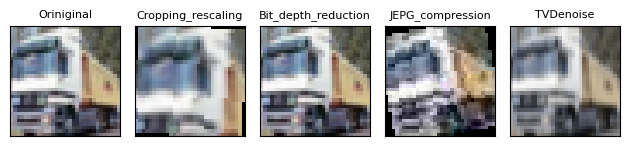

In [78]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision.transforms as T



testset = torchvision.datasets.CIFAR10(root='/home/eva_share/datasets/cifar10', train=True, download=True)
plt.rcParams["savefig.bbox"] = 'tight'
orig_img = testset[1][0]
# if you change the seed, make sure that the randomly-applied transforms
# properly show that the image can be both transformed and *not* transformed!
torch.manual_seed(0)


def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
       
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(title=row_title[col_idx])
            ax.title.set_size(8)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    # if with_orig:
    #     axs[0, 0].set(title='Original image')
    #     axs[0, 0].title.set_size(8)
    # if row_title is not None:
    #     for row_idx in range(num_rows):
    #         axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

import torchvision.transforms.functional as F

row_title = ['Oriniginal','Cropping_rescaling', 'Bit_depth_reduction','JEPG_compression','TVDenoise' ]
img1 = image_transforms['cropping_rescaling'](orig_img)
img2 = image_transforms['bit_depth_reduction'](orig_img)
img3 = image_transforms['JEPG_compression'](orig_img)
img4 = image_transforms['TVDenoise'](orig_img)


plot([orig_img,img1,img2,img3,img4],row_title=row_title)

In [14]:
# modelsInfo = [{'whether_denoising': False, 
#                'filter_type': 'Mean_Filter', 
#                'transform': None,
#                'address':'/content/drive/MyDrive/Colab Notebooks/FalseMean_FilterNone.pkl'},
#               {'whether_denoising': False, 
#                'filter_type': 'Mean_Filter', 
#                'transform': 'cropping_rescaling',
#                'address': '/content/drive/MyDrive/Colab Notebooks/FalseMean_Filtercropping_rescaling.pkl'}, 
#               {'whether_denoising': False, 
#                'filter_type': 'Mean_Filter', 
#                'transform': 'bit_depth_reduction',
#                'address':'/content/drive/MyDrive/Colab Notebooks/FalseMean_Filterbit_depth_reduction.pkl'},
#               {'whether_denoising': False, 
#                'filter_type': 'Mean_Filter', 
#                'transform': 'JEPG_compression',
#                'address': '/content/drive/MyDrive/Colab Notebooks/FalseMean_FilterJEPG_compression.pkl'},
#               {'whether_denoising': False, 
#                'filter_type': 'Mean_Filter', 
#                'transform': 'TVDenoise',
#                'address':'/content/drive/MyDrive/Colab Notebooks/FalseMean_FilterTVDenoise.pkl'}]
# epsilon_range = [0.0,5]
# plottingAttack(modelsInfo, epsilon_range, testloader)

In [15]:
# modelsInfo = [{'whether_denoising': False, 
#                'filter_type': 'Mean_Filter', 
#                'transform': None,
#                'address':'/content/drive/MyDrive/Colab Notebooks/FalseMean_FilterNone.pkl'},
#               {'whether_denoising': True, 
#                'filter_type': 'Mean_Filter', 
#                'transform': 'JEPG_compression',
#                'address': '/content/drive/MyDrive/Colab Notebooks/TrueMean_FilterJEPG_compression.pkl'}, 
#               {'whether_denoising': True, 
#                'filter_type': 'Mean_Filter', 
#                'transform': None,
#                'address':'/content/drive/MyDrive/Colab Notebooks/TrueMean_FilterNone.pkl'},
#               {'whether_denoising': False, 
#                'filter_type': 'Mean_Filter', 
#                'transform': 'JEPG_compression',
#                'address': '/content/drive/MyDrive/Colab Notebooks/FalseMean_FilterJEPG_compression.pkl'}]
# epsilon_range = [0.0,5]
# plottingAttack(modelsInfo, epsilon_range, testloader)

# Reference

Adversarial attack:
* https://github.com/JasonTang99/csc2529_project/blob/main/attack.py
* https://github.com/cleverhans-lab/cleverhans/blob/master/cleverhans/jax/attacks/fast_gradient_method.py


Countering Adversarial Images Using Input Transformations:
* https://github.com/facebookarchive/adversarial_image_defenses
* https://arxiv.org/pdf/1812.03411.pdf

Data Transformation: 
* https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/
* JPEG tranformation: https://discuss.pytorch.org/t/how-can-i-develop-a-transformation-that-performs-jpeg-compression-with-a-random-qf/43588/4
* TV denoise using bregman algorithm: https://github.com/shakes76/PatternFlow/blob/master/algorithms/denoise/denoise_tv_bregman/denoise_tv_bregman.py

Others:
* https://github.com/tqdm/tqdm
